A1 - Entropy(Response): 0.6076014117937689
A2 - Gini(Response): 0.253748405612245
A3 - Best root feature: AcceptedCmp5 | Info Gain: 0.05423514061257961
A4 - Equal-width bin counts for AcceptedCmp5:
 {'bin_0': 2077, 'bin_3': 163, 'bin_1': 0, 'bin_2': 0}
A5 - Top features selected for tree: ['AcceptedCmp5', 'AcceptedCmp1', 'MntWines', 'AcceptedCmp3', 'MntMeatProducts', 'Recency']


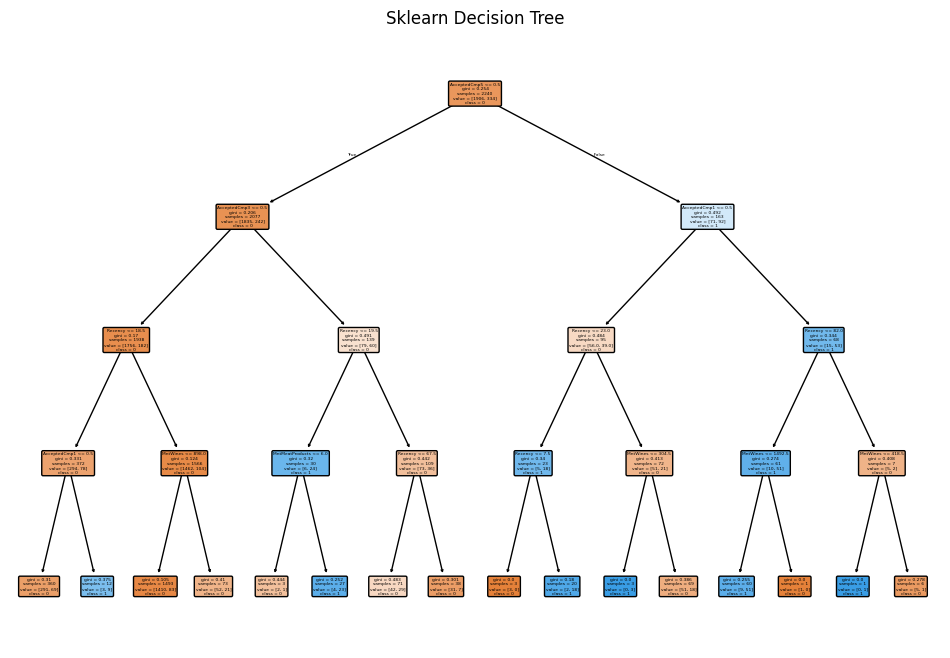

A5 - Trained sklearn DecisionTreeClassifier and plotted it.
A7 - Plotting decision boundary for: ('MntWines', 'Income')


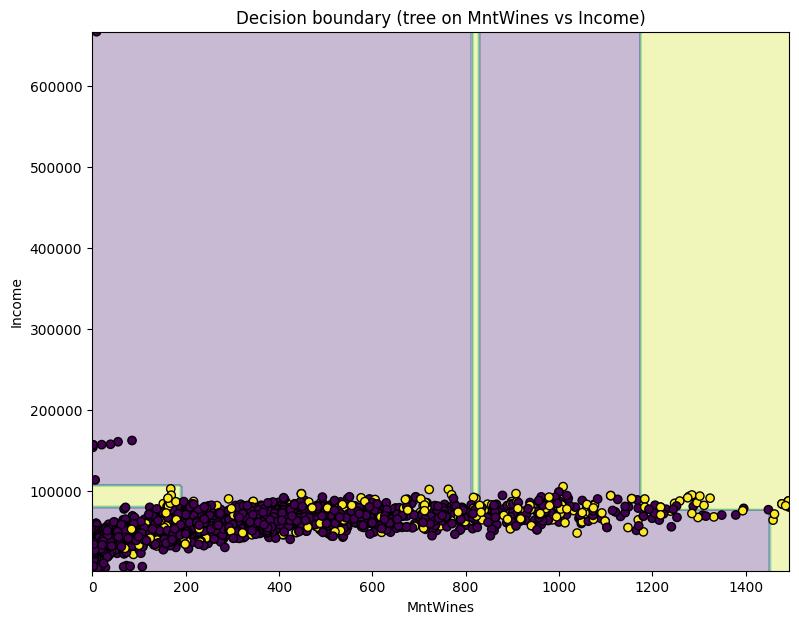

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings("ignore")
# ----------------- Utilities -----------------
def entropy(series: pd.Series) -> float:
    p = series.value_counts(normalize=True)
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum())

def gini(series: pd.Series) -> float:
    p = series.value_counts(normalize=True)
    return float(1.0 - (p ** 2).sum())

def safe_numeric(series: pd.Series):
    """Return numeric version of series (coerce errors)."""
    return pd.to_numeric(series, errors="coerce")

# ----------------- Binning (simple) -----------------
def equal_width_bins(series: pd.Series, bins: int = 4):
    """Return categorical Series of equal-width bins aligned to original index."""
    num = safe_numeric(series)
    if num.dropna().empty or num.nunique() == 1:
        return pd.Series(["bin_0"] * len(series), index=series.index, dtype="category")
    labels = [f"bin_{i}" for i in range(bins)]
    b = pd.cut(num, bins=bins, labels=labels, include_lowest=True)
    return b.astype("category")

# ----------------- Information gain -----------------
def information_gain(X_col: pd.Series, y: pd.Series, bin_numeric: bool = True, bins: int = 4):
    """Compute information gain H(y) - H(y | X_col)."""
    parent_H = entropy(y)
    # if numeric and user chose to bin, bin it; else treat as categorical
    if pd.api.types.is_numeric_dtype(X_col) and bin_numeric:
        feat = equal_width_bins(X_col, bins=bins)
    else:
        feat = X_col.fillna("NA").astype("category")
    total = len(y)
    weighted_H = 0.0
    # groupby on feat; groupby will skip NaN bins by default (pd.cut can produce NaN)
    for cat, idxs in feat.groupby(feat).groups.items():
        subset_y = y.loc[idxs]
        weight = len(subset_y) / total
        weighted_H += weight * entropy(subset_y)
    return parent_H - weighted_H

def best_feature_by_gain(df: pd.DataFrame, target_col: str, bin_numeric: bool = True, bins: int = 4):
    best_feat = None
    best_gain = -np.inf
    for col in df.columns:
        if col == target_col:
            continue
        # skip ID-like columns or columns that are unique for every row
        if col.lower() in ("id", "identifier") or df[col].nunique() == len(df):
            continue
        try:
            gain = information_gain(df[col], df[target_col], bin_numeric=bin_numeric, bins=bins)
            if gain > best_gain:
                best_gain = gain
                best_feat = col
        except Exception:
            continue
    return best_feat, best_gain

# ----------------- Simple sklearn tree training & plotting -----------------
def encode_df_for_sklearn(X: pd.DataFrame):
    X_enc = X.copy()
    encoders = {}
    for col in X_enc.columns:
        if X_enc[col].dtype == object or pd.api.types.is_categorical_dtype(X_enc[col]):
            le = LabelEncoder()
            X_enc[col] = le.fit_transform(X_enc[col].astype(str).fillna("NA"))
            encoders[col] = le
        else:
            X_enc[col] = safe_numeric(X_enc[col]).fillna(X_enc[col].median())
    return X_enc, encoders

def train_and_plot_sklearn_tree(df: pd.DataFrame, target_col: str, max_depth: int = 4, save_png: str = None):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_enc, _ = encode_df_for_sklearn(X)
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    clf.fit(X_enc, y)
    plt.figure(figsize=(12, 8))
    plot_tree(clf, feature_names=X_enc.columns, class_names=[str(c) for c in sorted(y.unique())],
              filled=True, rounded=True)
    plt.title("Sklearn Decision Tree")
    if save_png:
        plt.savefig(save_png, bbox_inches="tight")
    plt.show()
    return clf, X_enc.columns.tolist()

# ----------------- Decision boundary for two features -----------------
def plot_decision_boundary(df: pd.DataFrame, target_col: str, feat_x: str, feat_y: str, clf=None, steps=200):
    # Prepare 2-feature dataset; encode if categorical
    X = df[[feat_x, feat_y]].copy()
    y = df[target_col].copy()
    # Convert or encode columns
    encoders = {}
    for col in [feat_x, feat_y]:
        if X[col].dtype == object or pd.api.types.is_categorical_dtype(X[col]):
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str).fillna("NA"))
            encoders[col] = le
        else:
            X[col] = safe_numeric(X[col]).fillna(X[col].median())
    if clf is None:
        clf = DecisionTreeClassifier(max_depth=4, random_state=0)
        clf.fit(X.values, y.values)

    x_min, x_max = X[feat_x].min() - 1, X[feat_x].max() + 1
    y_min, y_max = X[feat_y].min() - 1, X[feat_y].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(9, 7))
    plt.contourf(xx, yy, Z, alpha=0.3)
    scatter = plt.scatter(X[feat_x], X[feat_y], c=y.values, edgecolor="k")
    plt.xlabel(feat_x)
    plt.ylabel(feat_y)
    plt.title(f"Decision boundary (tree on {feat_x} vs {feat_y})")
    plt.show()
    return clf

# ----------------- Main -----------------
def main():
    df = pd.read_csv("MC.csv")
    if "Response" not in df.columns:
        raise KeyError("MC.csv must contain 'Response' column as target.")

    # drop noise columns if present
    drop_cols = ["ID", "Dt_Customer", "Z_CostContact", "Z_Revenue"]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])

    target = "Response"

    # A1
    H = entropy(df[target])
    print("A1 - Entropy(Response):", H)

    # A2
    G = gini(df[target])
    print("A2 - Gini(Response):", G)

    # A3 - best root by info gain using equal-width binning of numeric features
    best_feat, best_gain = best_feature_by_gain(df, target_col=target, bin_numeric=True, bins=4)
    print("A3 - Best root feature:", best_feat, "| Info Gain:", best_gain)

    # A4 - show bin counts if best feature is numeric
    if best_feat is not None and pd.api.types.is_numeric_dtype(df[best_feat]):
        ew = equal_width_bins(df[best_feat], bins=4)
        print(f"A4 - Equal-width bin counts for {best_feat}:\n", ew.value_counts(dropna=False).to_dict())
    else:
        print(f"A4 - Best feature '{best_feat}' not numeric or not found; skipping bin counts.")

    # A5 - train sklearn decision tree on top features (pick top 6 by gain quickly)
    gains = []
    for col in df.drop(columns=[target]).columns:
        try:
            g = information_gain(df[col], df[target], bin_numeric=True, bins=4)
            gains.append((col, g))
        except Exception:
            continue
    gains_sorted = sorted(gains, key=lambda x: x[1], reverse=True)
    top_feats = [c for c, _ in gains_sorted[:6]] if gains_sorted else df.drop(columns=[target]).columns.tolist()[:6]
    print("A5 - Top features selected for tree:", top_feats)

    clf, feat_names = None, None
    try:
        clf, feat_names = train_and_plot_sklearn_tree(df[[*top_feats, target]], target, max_depth=4, save_png=None)
        print("A6 - Trained sklearn DecisionTreeClassifier and plotted it.")
    except Exception as e:
        print("A5 - sklearn tree failed:", e)

    # A7 - decision boundary for two numeric features (prefer MntWines & Income)
    preferred = ("MntWines", "Income")
    if preferred[0] in df.columns and preferred[1] in df.columns:
        print("A7 - Plotting decision boundary for:", preferred)
        plot_decision_boundary(df, target, preferred[0], preferred[1], clf=None)
    else:
        # fallback to first two numeric columns (aside from target)
        numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != target]
        if len(numeric_cols) >= 2:
            pair = (numeric_cols[0], numeric_cols[1])
            print("A7 - Preferred not found. Plotting decision boundary for:", pair)
            plot_decision_boundary(df, target, pair[0], pair[1], clf=None)
        else:
            print("A7 - Not enough numeric features to plot decision boundary; skipping.")

if __name__ == "__main__":
    main()